In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
from IPython.display import  display
from PIL import Image
import re
import string
from numpy import array

In [2]:
import tensorflow as tf  
print(tf.__version__)    
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, MaxPooling2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, \
    Lambda, Multiply, LSTM, Bidirectional, PReLU, MaxPooling1D
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint   
import time
from sklearn.model_selection import train_test_split
import cv2
import zipfile
import os
from google.colab.patches import cv2_imshow
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
from tensorflow.python.keras.layers.pooling import GlobalMaxPool2D
from pickle import load
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Add

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
# from tensorflow.keras.layers.merge import add
from tensorflow.keras.callbacks import ModelCheckpoint


2.7.0


In [3]:
!wget https://raw.githubusercontent.com/Nadiam75/DeepLearning_HW_3/main/Flickr_8k.trainImages.txt

--2022-01-07 09:22:07--  https://raw.githubusercontent.com/Nadiam75/DeepLearning_HW_3/main/Flickr_8k.trainImages.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154678 (151K) [text/plain]
Saving to: ‘Flickr_8k.trainImages.txt.1’

Flickr_8k.trainImag 100%[===================>] 151.05K  --.-KB/s    in 0.02s   

2022-01-07 09:22:07 (6.47 MB/s) - ‘Flickr_8k.trainImages.txt.1’ saved [154678/154678]



In [4]:
! pip install kaggle
# !wget https://github.com/Nadiam75/DeepLearning_HW_3/blob/main/kaggle.json
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d adityajn105/flickr8k

mkdir: cannot create directory ‘/root/.kaggle’: File exists
flickr8k.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
# !unzip -q /content/flickr8k.zip

In [6]:
images_path = './Images/'
captions_path = 'captions.txt'

In [7]:
captions = open(captions_path, 'r').read().split("\n")

In [8]:
tokens = {}
for ix in range(len(captions)-1):
    temp = captions[ix].split(",")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][:])
    else:
        tokens[temp[0]] = [temp[1][:]]

In [9]:
tokens['1003163366_44323f5815.jpg']

['A man lays on a bench while his dog sits by him .',
 'A man lays on the bench to which a white dog is also tied .',
 'a man sleeping on a bench outside with a white and black dog sitting next to him .',
 'A shirtless man lies on a park bench with his dog .',
 'man laying on bench holding leash of dog sitting on ground']

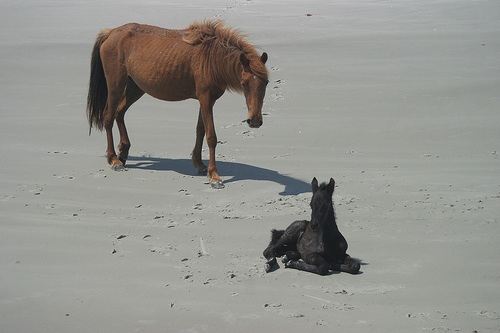

A brown horse and a black foal on the beach
A brown horse stands near a black horse that is sitting on the ground .
A large brown horse stands over a small black colt that is kneeling on the sand .
An adult horse approaching a foal on a sandy plain .
A thin brown horse standing and a small black horse sitting on sand .


In [10]:
temp = captions[1000].split(",")
z = Image.open(images_path+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

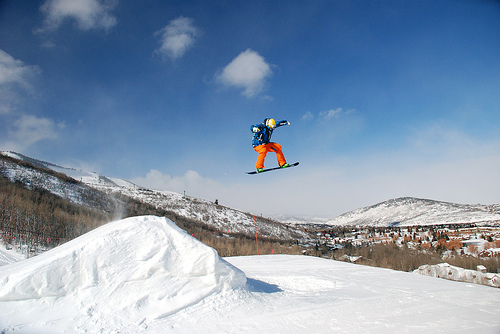

A man jumps off a ramp on a snowboard .
A snowboarder high in the air .
A snowboarder jumps through the air on their snowboard .
"Snowboarder flies off of snowy jump 
The snowboarder is in the middle of a very tall jump


In [11]:
temp = captions[6000].split(",")
z = Image.open(images_path+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

In [12]:
if 'image' in tokens.keys():
  del tokens['image']

In [13]:
i = 0
for key, value in tokens.items():
  i+=1
  if i>5:
    break
  print(key)  
  print("***********************")
  for j in range(len(value)):
    print(value[j])
  # print(value)
  print("----------------------------------------------------------------------------------------")

1000268201_693b08cb0e.jpg
***********************
A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .
A little girl in a pink dress going into a wooden cabin .
----------------------------------------------------------------------------------------
1001773457_577c3a7d70.jpg
***********************
A black dog and a spotted dog are fighting
A black dog and a tri-colored dog playing with each other on the road .
A black dog and a white dog with brown spots are staring at each other in the street .
Two dogs of different breeds looking at each other on the road .
Two dogs on pavement moving toward each other .
----------------------------------------------------------------------------------------
1002674143_1b742ab4b8.jpg
***********************
A little girl covered in paint sits in front of a painted rainbow with her hands in a 

In [14]:

# import string
 
# def clean_descriptions(descriptions):
# 	# prepare translation table for removing punctuation
# 	table = str.maketrans('', '', string.punctuation)
# 	for key, desc_list in descriptions.items():
# 		for i in range(len(desc_list)):
# 			desc = desc_list[i]
# 			# tokenize
# 			desc = desc.split()
# 			# convert to lower case
# 			desc = [word.lower() for word in desc]
# 			# remove punctuation from each token
# 			desc = [w.translate(table) for w in desc]
# 			# remove hanging 's' and 'a'
# 			desc = [word for word in desc if len(word)>1]
# 			# remove tokens with numbers in them
# 			desc = [word for word in desc if word.isalpha()]
# 			# store as string
# 			desc_list[i] =  ' '.join(desc)
 
# # clean descriptions
# clean_descriptions(descriptions)

In [15]:
def sentence_cleaning(sentence  ):
    sentence=sentence.lower()
    sentence=re.sub('[^a-z]+',' ',sentence)
    sentence=sentence.split()
    sentence=[s for s in sentence if len(s)>1]
    sentence=' '.join(sentence)
    return(sentence)

In [16]:
sentence_cleaning('Two dogs on pavement moving toward each other .' )

'two dogs on pavement moving toward each other'

In [17]:
sentence_cleaning('A young child is walking on 22 stones paved street with a metal pole and a man behind him .' )

'young child is walking on stones paved street with metal pole and man behind him'

In [18]:
i = 0
unique = set()
occurances = {}
clean_dictionary = {}
for key, value in tokens.items():
  for j in range(len(value)):
    if key in clean_dictionary:
      cleaned = sentence_cleaning(value[j] )
      clean_dictionary[key].append( cleaned)
    else:
      cleaned = sentence_cleaning(value[j] )
      clean_dictionary[key] = [cleaned]
    words = cleaned.split()

    for word in words:
      if word in occurances:
        occurances[word] += 1
      else:
        occurances[word] = 1
      unique.add(word)


In [19]:
clean_dictionary['934375844_dd149fed18.jpg']

['baby in white top is sitting on bed',
 'baby wearing my best buddy shirt on bed',
 'cute baby boy is sitting on the bed looking very happy',
 'small baby sits on bed and smiles',
 'small boy wearing blue shorts sitting on bed']

In [20]:
# unique_copy = unique.copy()

In [21]:
# counts = {}

# for key, value in clean_dictionary.items():
#   for j in range(len(value)):
    
#     words = value[j].split()
#     for word in words:
#       if word in counts :
#         counts [word] +=1
#       else:
#         counts[word] = 1

In [22]:
# def to_vocabulary(descriptions):
# 	# build a list of all description strings
# 	all_desc = set()
# 	for key in descriptions.keys():
# 		[all_desc.update(d.split()) for d in descriptions[key]]
# 	return all_desc

In [23]:
# vocabulary = to_vocabulary(clean_dictionary)
# print('Vocabulary Size: %d' % len(vocabulary))

In [24]:
cnt=0
low_occurance_dictionary = {}
# low_occurance_keys = []
for key, value in occurances.items():
  if value<10:
    cnt+=1
    low_occurance_dictionary[key] = value
    # low_occurance_keys.append(' '+key+ ' ')
    unique.remove(key)

In [25]:
len(unique)

1911

In [26]:
len(low_occurance_dictionary)

6346

In [27]:
# start_token = '<START> '
# end_token = ' <END>'
# pad_token = ' <PAD> '
# temp = r'(\s+' + r'\s+|\s+'.join(list(low_occurance_dictionary.keys())) + r'\s+)'
# # temp2 = ' '.join(list(low_occurance_dictionary.keys()))

In [28]:
start_token = '<START> '
end_token = ' <END>'
pad_token = ' <PAD> '


temp = r' | '.join(list(low_occurance_dictionary.keys()))

In [29]:
for i in range(3):
  for key, value in clean_dictionary.items():
    # print(key)
    for j in range(len(value)):

      value[j] = re.sub(temp, ' ' , value[j])
      value[j] = ' ' + value[j] + ' '

In [30]:
for key, value in clean_dictionary.items():
  # print(key)
  for j in range(len(value)):
    # value[j] = re.sub(temp, ' ' , value[j])
    value[j] = start_token + value[j] + end_token


In [31]:
for key, value in clean_dictionary.items():
  # print(key)
  for j in range(len(value)):
    value[j] = re.sub('\s+', ' ' , value[j])
    # value[j] = start_token + value[j] + end_token

In [32]:
i = 0
unique_prime = set()
occurances_prime = {}
for key, value in clean_dictionary.items():
  for j in range(len(value)):

    words = value[j].split()


    for word in words:
      if word in occurances_prime:
        occurances_prime[word] += 1
      else:
        occurances_prime[word] = 1
        unique_prime.add(word)

In [33]:
tokens['934375844_dd149fed18.jpg']

['A baby in a white top is sitting on a bed .',
 '"A baby wearing a "" my best buddy "" shirt on a bed ."',
 'A cute baby boy is sitting on the bed looking very happy .',
 'A small baby sits on a bed and smiles .',
 'Small boy wearing blue shorts sitting on bed .']

In [34]:
clean_dictionary['934375844_dd149fed18.jpg']

['<START> baby in white top is sitting on bed <END>',
 '<START> baby wearing shirt on bed <END>',
 '<START> baby boy is sitting on the bed looking very happy <END>',
 '<START> small baby sits on bed and smiles <END>',
 '<START> small boy wearing blue shorts sitting on bed <END>']

In [35]:
len(unique)

1911

In [36]:
len(unique_prime)

1913

In [37]:
i = 0
for key, value in clean_dictionary.items():
  i+=1
  if i>5:
    break
  print(key)  
  print("***********************")
  for j in range(len(value)):
    print(value[j])
    
  # print(value)
  print("----------------------------------------------------------------------------------------")

1000268201_693b08cb0e.jpg
***********************
<START> child in pink dress is climbing up set of stairs in an way <END>
<START> girl going into wooden building <END>
<START> little girl climbing into wooden <END>
<START> little girl climbing the stairs to her <END>
<START> little girl in pink dress going into wooden <END>
----------------------------------------------------------------------------------------
1001773457_577c3a7d70.jpg
***********************
<START> black dog and spotted dog are fighting <END>
<START> black dog and tri colored dog playing with each other on the road <END>
<START> black dog and white dog with brown spots are staring at each other in the street <END>
<START> two dogs of different looking at each other on the road <END>
<START> two dogs on pavement moving toward each other <END>
----------------------------------------------------------------------------------------
1002674143_1b742ab4b8.jpg
***********************
<START> little girl covered in paint 

In [38]:
with open('Flickr_8k.trainImages.txt') as f:
    trainKeys = [line.rstrip() for line in f]

In [39]:
train = {} 
test = {}
for item , value in clean_dictionary.items():
  if item in trainKeys:
    train[item] = value
  else:
    test[item] = value

In [40]:
# model = tf.keras.applications.VGG16( include_top= True , weights="imagenet",  input_tensor=None,  input_shape=None,   pooling=None,  classes=1000,   classifier_activation="softmax")# re-structure the model
# model = Model(inputs=model.inputs, outputs=model.layers[-2].output  )
# model.summary()


In [41]:
from keras.preprocessing.image import img_to_array

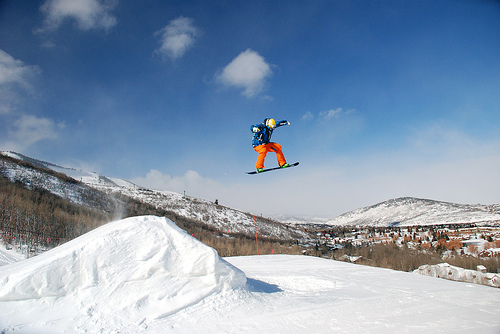

<START> man jumps off ramp on snowboard <END>
<START> snowboarder high in the air <END>
<START> snowboarder jumps through the air on their snowboard <END>
<START> snowboarder flies off of snowy jump <END>
<START> the snowboarder is in the middle of very tall jump <END>


In [42]:
temp = captions[6000].split(",")
z = Image.open(images_path+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(clean_dictionary[temp[0]][ix])
image = img_to_array(z)

In [43]:
# extract features from each photo in the directory
def encode(filename  , model ):
	# load the model

	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature

In [44]:
# encodedTrain = {} 
# i = 0
# for key, value in train.items():
#   i+=1
#   if i%100 == 0:
#     print(i)
#   path = 'Images/' +key
#   encoded = encode(path , model )
#   encodedTrain[key] = encoded

In [45]:
# import pickle
# print('Extracted Train Features: %d' % len(encodedTrain))
# # save to file
# pickle.dump(encodedTrain, open('encodedTrain.pkl', 'wb'))

In [46]:
# encodedTest = {} 
# i=0
# for key, value in test.items():
#   i+=1
#   if i%100 == 0:
#     print(i)
#   path = 'Images/' +key
#   encoded = encode(path, model)
#   encodedTest[key] = encoded

In [47]:
import pickle
file = open("./drive/MyDrive/train_features.pkl",'rb')
encodedTrain = pickle.load(file)

file = open("./drive/MyDrive/test_features.pkl",'rb')
encodedTest = pickle.load(file)

In [48]:
print('Extracted Test Features: %d' % len(encodedTest))


Extracted Test Features: 2091


In [49]:
print('Dataset: %d' % len(train))
print('Photos: train= %d' % len(encodedTrain))

Dataset: 6000
Photos: train= 6000


In [50]:
def load_photo_features(fileKey):
	if fileKey in encodedTrain:
		print(" feature found among train feautures")
		return encodedTrain[fileKey]
	elif fileKey in encodedTest:
		print(" feature found among test feautures")
		return encodedTest[fileKey]

In [51]:
# with open('saved_test_dictionary.pkl', 'wb') as f:
#     # pickle.dump(encodedTrain, f)
#     f.write(pickle.dumps(encodedTest))
    
        
# with open('saved_test_dictionary.pkl', 'rb') as f:
#     # encodedTrain = pickle.load(f)
#     encodedTest = pickle.loads(f.read())

In [52]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key , values in descriptions.items():
		[all_desc.append(d) for d in values]
	return all_desc

In [53]:
train['1007320043_627395c3d8.jpg']

['<START> child playing on rope net <END>',
 '<START> little girl climbing on red <END>',
 '<START> little girl in pink climbs rope bridge at the park <END>',
 '<START> small child onto the red ropes at the playground <END>',
 '<START> the small child climbs on red ropes on playground <END>']

In [54]:
# convert a dictionary of clean descriptions to a list of descriptions
def tol(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

In [55]:
# calculate the length of the description with the most words
def max_length(descriptions):
	lines = tol(descriptions)
	return max(len(d.split()) for d in lines)

In [56]:
max_length(train)

29

In [57]:
maximumLength = 0
for line in to_lines(train):
  
  length = len(line.split())
  if length> maximumLength:
    maximumLength = length 
print (f'maximum length is {maximumLength}')

maximum length is 29


In [58]:
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer(num_words=4000)
	tokenizer.fit_on_texts(lines)
	return tokenizer

In [59]:
tokenizer = create_tokenizer(train)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 1913


In [60]:
# tokenizer = create_tokenizer(unique)
# vocab_size = len(tokenizer.word_index) + 1
# print('Vocabulary Size: %d' % vocab_size)

In [61]:
del captions , clean_dictionary 

In [62]:
# # create sequences of images, input sequences and output words for an image
# def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
# 	X1, X2, y = list(), list(), list()
# 	# walk through each image identifier
# 	for key, desc_list in descriptions.items():
# 		# walk through each description for the image
# 		for desc in desc_list:
# 			# encode the sequence
# 			seq = tokenizer.texts_to_sequences([desc])[0]
# 			# split one sequence into multiple X,y pairs
# 			for i in range(1, len(seq)):
# 				# split into input and output pair
# 				in_seq, out_seq = seq[:i], seq[i]
# 				# pad input sequence
# 				in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
# 				# encode output sequence
# 				out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
# 				# store
# 				X1.append(photos[key][0])
# 				X2.append(in_seq)
# 				y.append(out_seq)
# 	return array(X1), array(X2), array(y)

In [76]:
X1_train, X2_train, y_train = list(), list(), list()
# walk through each image identifier
i = 0
for key, desc_list in train.items():
  # walk through each description for the image
  for desc in desc_list:
    seq = tokenizer.texts_to_sequences([desc])[0]
    # split one sequence into multiple X,y pairs
    for i in range(1, len(seq)):
      in_seq, out_seq = seq[:i], seq[i]
      in_seq = pad_sequences([in_seq], maxlen=maximumLength)[0]
      out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
      X1_train.append(encodedTrain[key][0])
      X2_train.append(in_seq)
      y_train.append(out_seq)

In [77]:
X1_test, X2_test, y_test = list(), list(), list()
# walk through each image identifier
i = 0
for key, desc_list in test.items():
  # walk through each description for the image
  for desc in desc_list:
    seq = tokenizer.texts_to_sequences([desc])[0]
    # split one sequence into multiple X,y pairs
    for i in range(1, len(seq)):
      in_seq, out_seq = seq[:i], seq[i]
      in_seq = pad_sequences([in_seq], maxlen=maximumLength)[0]
      out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
      X1_test.append(encodedTest[key][0])
      X2_test.append(in_seq)
      y_test.append(out_seq)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title_sequence (InputLayer)    [(None, 29)]         0           []                               
                                                                                                  
 photo_encoded (InputLayer)     [(None, 4096)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 29, 256)      489728      ['title_sequence[0][0]']         
                                                                                                  
 dropout_2 (Dropout)            (None, 4096)         0           ['photo_encoded[0][0]']          
                                                                                            

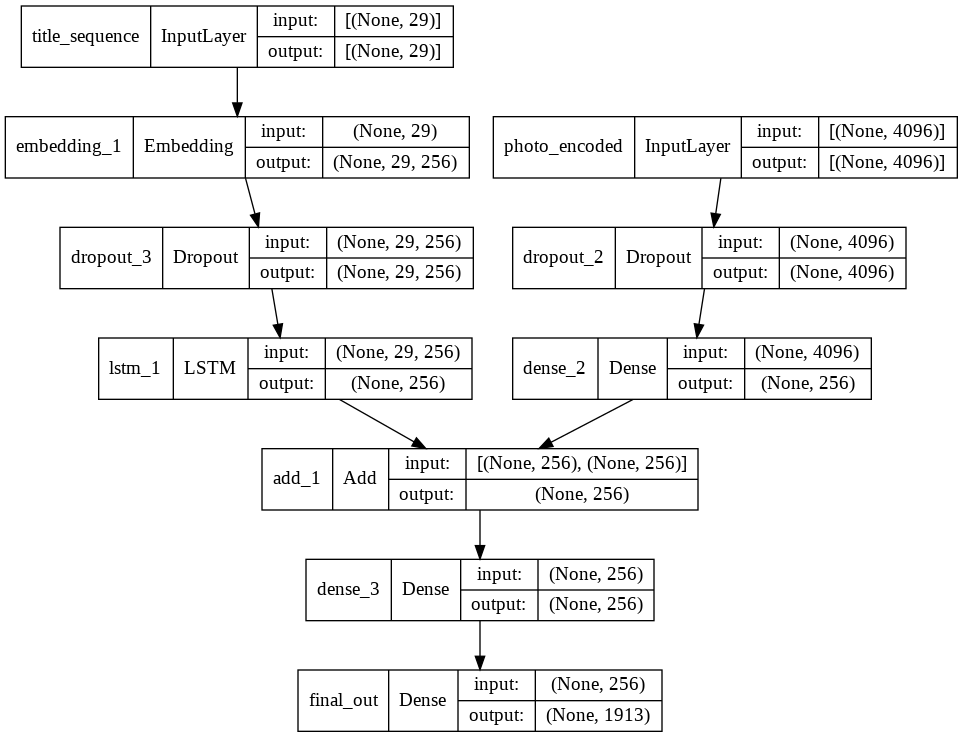

In [78]:
# define the captioning model
# def define_model(vocab_size, max_length):
	# feature extractor model
inputs1 = Input(shape=(4096,)  , name="photo_encoded")
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence model
inputs2 = Input(shape=(maximumLength,) , name= "title_sequence")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
# decoder model
# decoder1 = Add([fe2, se3])
decoder1  = tf.keras.layers.Add()([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax' , name="final_out")(decoder2)
# tie it together [image, seq] [word]
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
# summarize model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)
	# return model

In [79]:
# define checkpoint callback
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [80]:
# X1_train = np.array(X1_train)
# X2_train = np.array(X2_train)
# y_train =  np.array(y_train)
# X1_test = np.array(X1_test)
# X2_test = np.array(X2_test)
# y_test = np.array(y_test)

In [81]:
train_zipped = zip(X1_train, X2_train)
zipped_train_list = list(train_zipped)

In [82]:
test_zipped = zip(X1_test, X2_test)
zipped_test_list = list(test_zipped)

In [83]:
len(X1_train), len(X2_train) , len(y_train) , len(X1_test ) , len(X2_test) , len(y_test) , len (zipped_train_list) , len (zipped_test_list)

(284062, 284062, 284062, 98852, 98852, 98852, 284062, 98852)

In [84]:
# np.array(X1_train).shape ,np.array(X2_train).shape , np.array(y_train).shape

In [85]:
# np.array(X1_test).shape ,np.array(X2_test).shape , np.array(y_test).shape

In [86]:
datacount = 100000

In [87]:
X1_train = tf.stack(X1_train[:datacount])
X2_train = tf.stack(X2_train[:datacount])
y_train = tf.stack(y_train[:datacount])
X1_test = tf.stack(X1_test[:datacount])
X2_test = tf.stack(X2_test[:datacount])
y_test = tf.stack(y_test[:datacount])

In [88]:
# # fit model
# model.fit( {"photo_encoded": X1_train, "title_sequence": X2_train } , {'final_out' : y_train}, epochs=20,  batch_size=32 ,  verbose=1,  validation_data= (    {"photo_encoded": X1_test, "title_sequence": X2_test } , {'final_out' : y_test } ) )
# fit model
model.fit( {"photo_encoded": X1_train, "title_sequence": X2_train } , {'final_out' : y_train}, epochs=5, callbacks=[checkpoint] , batch_size=1024 ,  verbose=1 , validation_data= (    {"photo_encoded": X1_test, "title_sequence": X2_test } , {'final_out' : y_test } ) ) 

Epoch 1/5
98/98 [==============================] - ETA: 0s - loss: 5.1866
Epoch 00001: val_loss improved from inf to 4.86834, saving model to model-ep001-loss5.187-val_loss4.868.h5
98/98 [==============================] - 32s 266ms/step - loss: 5.1866 - val_loss: 4.8683
Epoch 2/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


98/98 [==============================] - ETA: 0s - loss: 4.1795
Epoch 00002: val_loss improved from 4.86834 to 4.19743, saving model to model-ep002-loss4.180-val_loss4.197.h5
98/98 [==============================] - 24s 244ms/step - loss: 4.1795 - val_loss: 4.1974
Epoch 3/5
98/98 [==============================] - ETA: 0s - loss: 3.5141
Epoch 00003: val_loss improved from 4.19743 to 3.98603, saving model to model-ep003-loss3.514-val_loss3.986.h5
98/98 [==============================] - 24s 241ms/step - loss: 3.5141 - val_loss: 3.9860
Epoch 4/5
98/98 [==============================] - ETA: 0s - loss: 3.1580
Epoch 00004: val_loss improved from 3.98603 to 3.91678, saving model to model-ep004-loss3.158-val_loss3.917.h5
98/98 [==============================] - 23s 232ms/step - loss: 3.1580 - val_loss: 3.9168
Epoch 5/5
98/98 [==============================] - ETA: 0s - loss: 2.9175
Epoch 00005: val_loss improved from 3.91678 to 3.91060, saving model to model-ep005-loss2.917-val_loss3.911.h5
